In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot
from time import time
import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import WF, WF_wrapper, GLU, GLU_wrapper, SLCP, SLCP_wrapper
from inference_utils import get_prior


model_dict = {'WF': [WF, WF_wrapper], 'GLU': [GLU, GLU_wrapper], 'SLCP': [SLCP, SLCP_wrapper]}

def get_prior_and_posterior(model):
    prior = get_prior(model)
    posterior = pickle.load(open(f'{model}/posteriors/posterior_{model}_100000_20.pkl', 'rb'))
    return prior, posterior

# Example - a single observation

## Wright-Fisher

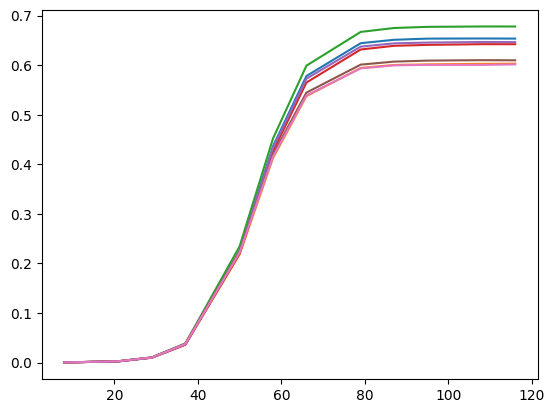

In [19]:
model = 'WF'
prior, posterior = get_prior_and_posterior(model)
simulator = model_dict[model][1]
generation = np.array(pd.read_csv('WF/empirical_data/Chuong_116_gens.txt').columns.astype('int'))

# WF parameters from Chuong et al 2024
th = torch.tensor([-0.74,-4.84,-4.32], dtype=torch.float32) # LTRΔ MAP in paper
X = simulator(parameters=th, reps=7) # 7 reps

for x in X:
    plt.plot(generation,x)

In [ ]:
epsilon = -150 # also from Chuong et al
Xs = torch.tensor(X)
op = CollectivePosterior(prior, posterior, Xs, 1, epsilon)
op.get_log_C()
samples = op.sample(100)
est = samples.mean(0)
print(est)

In [ ]:
from seaborn import histplot

fig, ax = plt.subplots(1,len(th))
for i in range(len(th)):
    histplot(samples[:,i], ax=ax[i], label='CP samples')
    ax[i].axvline(th[i], color='red', label='True parameter')
    ax[i].axvline(est[i], color='green', label='Sample mean')
ax[len(th)-1].legend()

## Gaussian Linear Uniform

In [ ]:
from seaborn import pairplot
model = 'GLU'
prior, posterior = get_prior_and_posterior(model)
simulator = model_dict[model][1]

# sample one observation
th = prior.sample((1,))[0]
print(th)
X = simulator(parameters=th, reps=50) # 10 reps

g = pairplot(pd.DataFrame(X.numpy()))
for i in range(len(th)):
    g.axes[i,i].axvline(th[i],color='red', linewidth=3)
    g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

tensor([-0.6565, -0.5464,  0.9029, -0.4270, -0.6578,  0.5678, -0.1849, -0.7443,
         0.9855,  0.4877])


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

In [ ]:
epsilon = -10000 # random low number
op = CollectivePosterior(prior, posterior, X, 1, epsilon)
op.get_log_C()
samples = op.sample(100)
est = samples.mean(0)
print(est)

## Evaluation on Synthetic Data

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


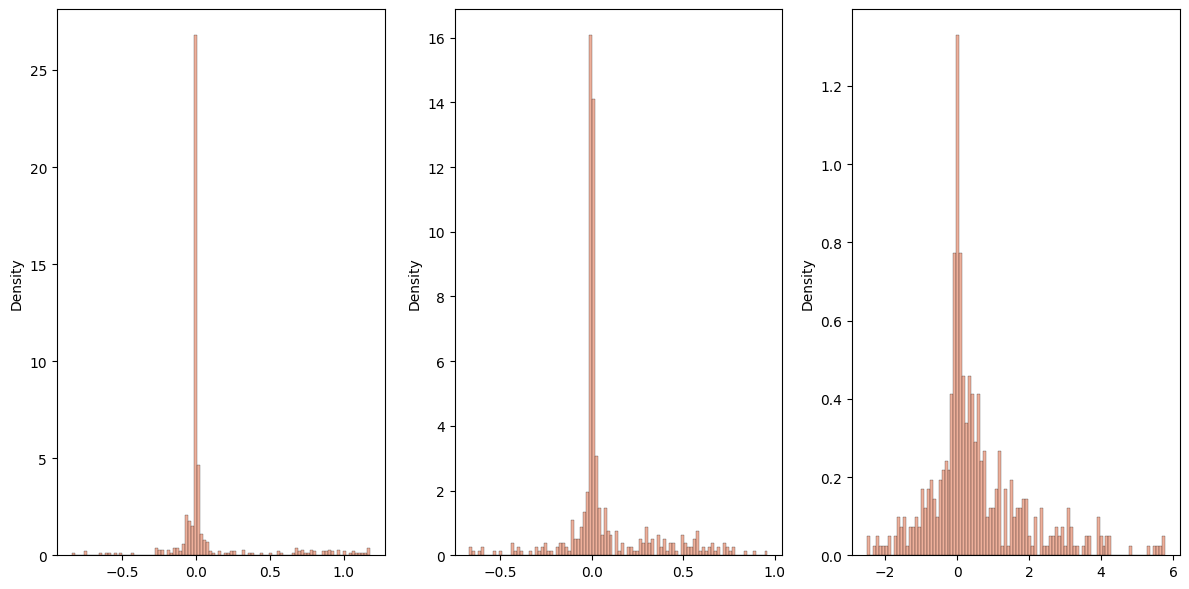

In [19]:
# Accuracy

def plot_accuracy(acc_path, ax, color):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(len(ax)):
        histplot(res[:,i],ax=ax[i], stat='density', color=color, bins=100)
    return

n_params=len(prior.base_dist.mean)
fig, ax = plt.subplots(1,n_params, figsize=(12,6), tight_layout=True, sharex=False)

cp_acc = f'{model}/tests/accus_{model}.csv'
plot_accuracy(cp_acc, ax, color='darksalmon')


/tmp/ipykernel_1200328/3837363581.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)


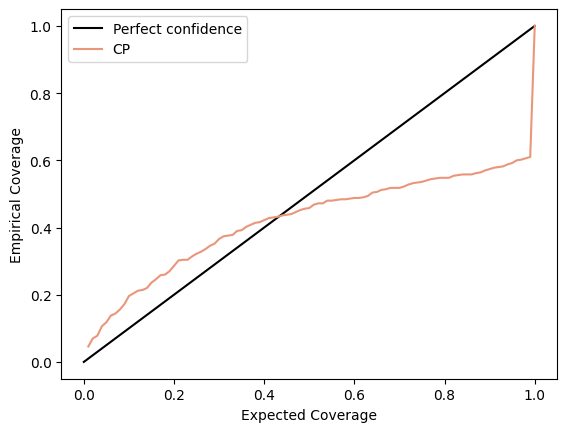

In [20]:
def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv(f'{model}/tests/covs_{model}.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')